In [117]:
import yfinance as yf
import openpyxl as xl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [128]:
CSV_FILE = 'Mom-Dec2022.csv'
TITLE_SECTOR_DISTRIBUTIONS = 'Account Distributions (December 2022)'
TITLE_ASSET_CLASSES = 'Asset Class Distribution (December 2022)'

In [119]:
df = pd.read_csv(CSV_FILE, header=2)

In [120]:
sector_weighting_conversions = {
    'realestate': 'Real Estate',
    'utilities': 'Utilities',
    'consumer_cyclical': 'Consumer Cyclical',
    'consumer_defensive': 'Consumer Defensive',
    'energy': 'Energy',
    'financial_services': 'Financial Services',
    'healthcare': 'Healthcare',
    'industrials': 'Industrials',
    'technology': 'Technology',
    'basic_materials': 'Basic Materials',
    'communication_services': 'Communication Services'
                                }

ticker_list = []
sector_weightings_in_account = {}
asset_classes_in_account = {}


def add_to_asset_classes(asset_class, amount):
    if type(amount) == str:
        amount = amount.strip('%')
    if asset_class not in asset_classes_in_account.keys():
        asset_classes_in_account[asset_class] = float(amount)
    elif asset_class in asset_classes_in_account.keys():
        asset_classes_in_account[asset_class] += float(amount)


def add_to_sector_weightings(sector, amount):
    if type(amount) == str:
        amount = amount.strip('%')
    if sector not in sector_weightings_in_account.keys():
        sector_weightings_in_account[sector] = float(amount)
    elif sector in sector_weightings_in_account.keys():
        sector_weightings_in_account[sector] += float(amount)


def add_to_sector_weightings_fund(weights_dict, total_amount_of_acct):
    if type(total_amount_of_acct) == str:
        total_amount_of_acct = total_amount_of_acct.strip('%')
    new_weightings_dict = {}
    check_total = float(0)
    for key in weights_dict.keys():
        holding_value = weights_dict[key]
        new_weightings_dict[key] = float(total_amount_of_acct) * holding_value
    for sector in new_weightings_dict.keys():
        check_total += new_weightings_dict[sector]
        if sector not in sector_weightings_in_account.keys():
            sector_weightings_in_account[sector] = new_weightings_dict[sector]
        elif sector in sector_weightings_in_account.keys():
            sector_weightings_in_account[sector] += new_weightings_dict[sector]
    print(f'Checking totals: Passed total was {total_amount_of_acct}, parsed was {check_total}.')
    remainder = float(total_amount_of_acct) - check_total
    print(f'Passing {remainder} to "Fund Remainder."')
    add_to_sector_weightings('Fund Remainder', remainder)


for row in df.index:
    ticker = df.at[row, 'Symbol']
    ticker_list.append(ticker)
    try:
        security_type = df.at[row, 'Security Type']
        if security_type == 'Equity':
            ticker_lookup = yf.Ticker(ticker)
            quote_type = ticker_lookup.info['quoteType']
            if quote_type == 'EQUITY':
                sector = ticker_lookup.info['sector']
                df.at[row, 'Sector'] = sector
                add_to_sector_weightings(sector, df.at[row, '% Of Account'])
                add_to_asset_classes(security_type, df.at[row, '% Of Account'])
                print(f'Added equity {ticker}.')
            elif quote_type == 'ETF':
                df.at[row, 'Security Type'] = 'Preferred Stock'
                df.at[row, 'Sector'] = 'Preferred Stock'
                add_to_sector_weightings('Fixed Income', df.at[row, '% Of Account'])
                add_to_asset_classes('Fixed Income', df.at[row, '% Of Account'])
                print(f'Adding preferred stock {ticker}.')
        elif security_type == 'ETFs & Closed End Funds' or security_type == 'Mutual Fund':
            ticker_lookup = yf.Ticker(ticker)
            weightings_dict = {}
            for item in ticker_lookup.info['sectorWeightings']:
                 for key, value in item.items():
                    new_key = sector_weighting_conversions[key]
                    weightings_dict[new_key] = value
            df.at[row, 'Sector'] = weightings_dict
            total_of_acct = df.at[row, '% Of Account']
            add_to_sector_weightings_fund(weightings_dict, total_of_acct)
            add_to_asset_classes(security_type, df.at[row, '% Of Account'])
            print(f'Adding ETF/Mutual Fund {ticker}.')
        elif security_type == 'Option':
            add_to_sector_weightings('Options', df.at[row, '% Of Account'])
            add_to_asset_classes(security_type, df.at[row, '% Of Account'])
            print(f'Adding option {ticker}')
        elif security_type == 'Fixed Income':
            add_to_sector_weightings('Fixed Income', df.at[row, '% Of Account'])
            add_to_asset_classes(security_type, df.at[row, '% Of Account'])
            print(f'Adding fixed income {ticker}')
        elif security_type == 'Cash and Money Market':
            cash_amount = df.at[row, '% Of Account']
            cash_amount = cash_amount.strip('%')
            sector_weightings_in_account['Cash'] = float(cash_amount)
            add_to_asset_classes(security_type, df.at[row, '% Of Account'])
        else:
            print(f'Skipping {ticker}')
    except Exception as e:
            print(f'Skipping {ticker} - Error: {e}')

print(sector_weightings_in_account)

Added equity MMM.
Added equity T.
Added equity ABBV.
Added equity AMD.
Added equity AMZN.
Added equity AMKR.
Added equity AVB.
Added equity BAC.
Added equity BX.
Added equity HRB.
Added equity BWA.
Added equity CENT.
Added equity CHH.
Added equity CSCO.
Added equity CURLF.
Added equity BROS.
Adding preferred stock EAI.
Added equity XOM.
Added equity FHN.
Added equity F.
Added equity GLPI.
Added equity HIW.
Added equity INTC.
Added equity KBH.
Added equity LAZ.
Added equity LDOS.
Added equity MPW.
Added equity MGM.
Added equity MSFT.
Added equity MC.
Added equity NVDA.
Added equity OLN.
Added equity OKE.
Added equity PAG.
Added equity RCII.
Added equity RCL.
Added equity SOFI.
Added equity SCS.
Added equity STOR.
Added equity SUN.
Added equity KO.
Added equity UI.
Added equity VLO.
Added equity WPC.
Added equity DIS.
Added equity WFC.
Checking totals: Passed total was 2.15, parsed was 2.1910649956999997.
Passing -0.04106499569999977 to "Fund Remainder."
Adding ETF/Mutual Fund PEY.
Check

In [121]:
total = float(0)
for key in sector_weightings_in_account.keys():
    total += sector_weightings_in_account[key]
print(total)

100.00000000000001


In [122]:
sector_weightings = pd.DataFrame(sector_weightings_in_account, columns=sector_weightings_in_account.keys(), index=['Account %'])
sector_weightings = sector_weightings.transpose()
sector_weightings = sector_weightings.sort_index()
sector_weightings

,Account %
Basic Materials,2.266236
Cash,10.440000
Communication Services,3.483978
Consumer Cyclical,9.833695
Consumer Defensive,3.945270
Energy,4.767571
Financial Services,8.517390
Fixed Income,15.490000
Fund Remainder,3.128991
Healthcare,4.735588


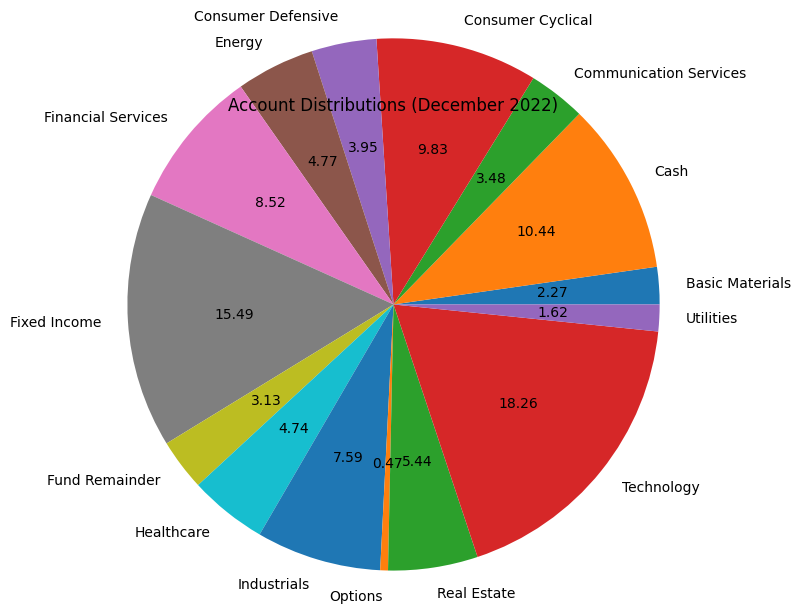

In [137]:
plt.pie(x=sector_weightings['Account %'], labels=sector_weightings.index, autopct='%.2f', radius=1.8, shadow=True)
plt.title(TITLE_SECTOR_DISTRIBUTIONS, pad=100)
plt.show()

In [125]:
asset_classes = pd.DataFrame(asset_classes_in_account, columns=asset_classes_in_account.keys(), index=['Account %'])
asset_classes = asset_classes.transpose()
asset_classes = asset_classes.sort_index()
asset_classes

,Account %
Cash and Money Market,10.44
ETFs & Closed End Funds,36.80
Equity,31.93
Fixed Income,15.49
Mutual Fund,4.87
Option,0.47


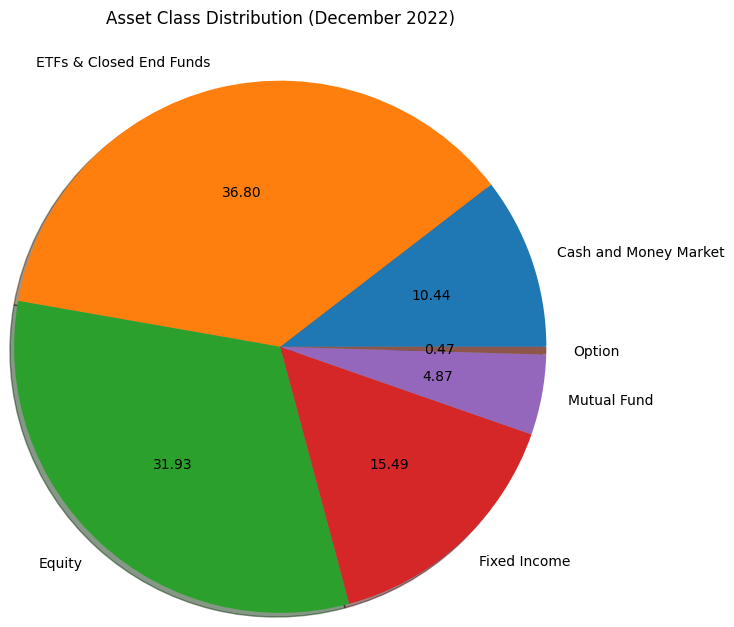

In [142]:
plt.pie(x=asset_classes['Account %'], labels=asset_classes.index, autopct='%.2f', radius=1.8, shadow=True)
plt.title(TITLE_ASSET_CLASSES, pad=100)
plt.show()